### Задача uplift-моделирования

### План занятия

* Введение: коммуникация с пользователями
* Дизайн эксперимента
* Типы клиентов
* Одна модель с дополнительным признаком
* Вариант с двумя независимыми моделями
* Вариант с двумя зависимыми моделями
* Прямой расчет uplift: "деревянные" модели
* Ссылки

### Введение

Часто возникает необходимость коммуникации с пользователями для продвижения сервисов и услуг.

Коммуникация осуществляется с помощью различных каналов: смс, звонки, push-уведомления, сообщения в чатботе и т.д

Например, мы хотим отправить push-уведомление игрокам в мобильной игре о том, что у них заполнились склады или об ином внутриигровом событии. Либо даже хотим отправить уведомление о наступающем внутриигровом эвенте (которые очень важны для активных игроков и для монетизации и развития игры в целом).

Другой пример:

Мы хотим прорекламировать популярный продукт, но при этом не хотим тратить бюджет на коммуникацию с пользователями, которые и без нас его купят. 

Изначально вопрос у нас такой: <b>Какова вероятность, что пользователь совершит нужное нам действие?</b>

Но нам нужен ответ не на него.

### Пример - задача прогнозирования оттока

Подробно задачу будем разбирать на следующем занятии, но давайте договоримся, что решать мы ее уже умеем.

Т.е мы для пользователей нашего сервиса можем посчитать вероятность ухода в отток.

![ab_split](churn.png "churn1")

Мы можем для пользователя определить вероятность:

P(User)

Мы хотим удерживать наших пользователей, которые чем-то недовольны или несчастны и хотим им предложить более выгодные условия подписки или тарифа (например, если мы - мобильный оператор, то мы можем предложить нашим абонентам более выгодный тариф).

Хорошо, мы можем отобрать из нашей аудитории наиболее "несчастных". Почему бы просто не сделать им предложение? В чем проблема? 

Проблема в том, что разные пользователи реагируют на коммуникацию по-разному и каждое взаимодействие стоит для нас денег.

И еще проблема - <b>наша модель неидеальна!</b>

#### Типы пользователей по реакции на коммуникацию

![ab_split](uplift_client_types.png "uplift_client_types")

1. Пользователи, которые совершат нужное действие независимо от коммуникации
2. Те, кто совершат действие, если будет коммуникация
3. Те, кто не совершит действие независимо от коммуникации
4. Не совершат действие, если коммуникация будет

Для оптимизации эффекта от воздействия хочется посчитать разницу реакций пользователя при наличии коммуникации и при ее отсутствии. 

Проблема в том, что мы не можем одновременно совершить коммуникацию и не совершить коммуникацию.

![ab_split](uplift2.png "uplift_cats")

Что же делать?

Необходимо оценить разницу между двумя событиями, которые являются взаимоисключающими для конкретного пользователя.

Для этого нам нужна обучающая выборка. А для нее нужно просто провести эксперимент. 

1. Берем часть базы пользователей и разбиваем на 2 группы: контрольную и экспериментальную
2. На экспериментальной группе запускаем маркетинговую кампанию (совершаем коммуникацию)
3. Через какое-то время у нас есть результаты совершения нужного действия клиентами в обеих группах (включая контрольную)
4. Проводим uplift-моделирование

![ab_split](uplift_3.png "uplift3")

![ab_split](uplift_scheme.png "uplift_scheme")

*взято из https://habr.com/ru/company/ru_mts/blog/485980/

### Пример модели с дополнительным признаком

Другие названия: Treatment Dummy approach, Solo model approach, Single model approach, S-Learner 

![ab_split](uplift_single_model.png "uplift_single_model")

### Две независимые модели

Другие названия: Two models approach, T-learner, difference two models

Интуитивно понятный и простой метод - моделируем 2 условные вероятности

1. обучаем модель прогноза вероятности совершения целевого действия для контрольной группы
2. обучаем модель прогноза вероятности совершения целевого действия для экспериментальной группы
3. на прогнозе - делаем прогноз для тестовых пользователей двумя моделями и вычитаем из прогноза второй модели прогноз первой

![ab_split](uplift_2models.png "uplift_2models")

p(y=1|w=1), p(y=1|w=0)

### ПЕРЕРЫВ ДО 20:56 (МСК)

### Практический пример с соревнования X5 

http://retailhero.ai/#rec141268104

Импортируем нужные библиотеки и предобработаем данные:

In [3]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

In [4]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


# Чтение данных
df_clients = pd.read_csv(path +'clients.csv', index_col='client_id')
df_train = pd.read_csv(path +'uplift_train.csv', index_col='client_id')
df_test = pd.read_csv(path +'uplift_test.csv', index_col='client_id')

# Извлечение признаков
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [5]:
df_clients

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
...,...,...,...,...
fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F
ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F


In [6]:
df_test.head(3)

""
client_id
000048b7a6
000073194a
00007c7133


In [7]:
df_train

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1
...,...,...
fffe0abb97,0,0
fffe0ed719,0,1
fffea1204c,0,1


In [8]:
df_train.groupby("treatment_flg")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment_flg,,,,,,,,
0,100058.0,0.603280,0.489219,0.0,0.0,1.0,1.0,1.0
1,99981.0,0.636511,0.481006,0.0,0.0,1.0,1.0,1.0


Заведем переменные

In [9]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [10]:
X_train.head()

,age,gender,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,
ad6561e2d8,50,F,1512322431,1.527102e+09,14779510.0
7c1ccbf93f,24,F,1510331629,1.519326e+09,8994516.0
b58fadcab6,36,U,1509657465,1.537045e+09,27387871.0
e99e6fabb9,79,F,1526466080,1.527713e+09,1247284.0
27fb6f8520,34,F,1500320188,1.513332e+09,13012137.0


In [11]:
treat_train

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
             ..
999d284453    1
f634deea4e    0
16cb4f99b0    0
23c2b72b2e    1
1430184499    0
Name: treatment_flg, Length: 140027, dtype: int64

In [12]:
y_train

client_id
ad6561e2d8    1
7c1ccbf93f    1
b58fadcab6    1
e99e6fabb9    0
27fb6f8520    1
             ..
999d284453    1
f634deea4e    1
16cb4f99b0    1
23c2b72b2e    1
1430184499    1
Name: target, Length: 140027, dtype: int64

In [13]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt


def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

![ab_split](uplift4.png "uplift4")

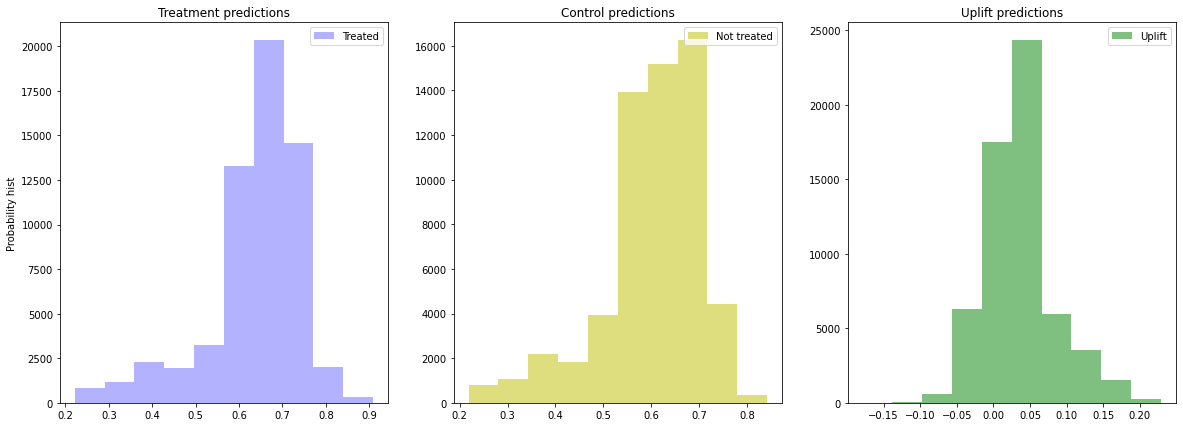

In [14]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

N =10000
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train.iloc[:N,:], y_train.iloc[:N], treat_train.iloc[:N], estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val[:N], uplift=uplift_sm[:N], treatment=treat_val[:N], strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds_(   sm_trmnt_preds , sm_ctrl_preds, bins=10);#ctrl_preds=

Посмотрим на топ-признаки

In [15]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,issue_redeem_delay,32.439270
1,first_redeem_time,24.022436
2,first_issue_time,16.776697
3,age,13.237028
4,treatment,8.106927
5,gender,5.417641


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

![ab_split](uplift5.png "uplift5")

![ab_split](uplift_client_types.png "uplift_client_types")

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-16-6e5ebc9c94ea>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

![ab_split](uplift6.png "uplift6")

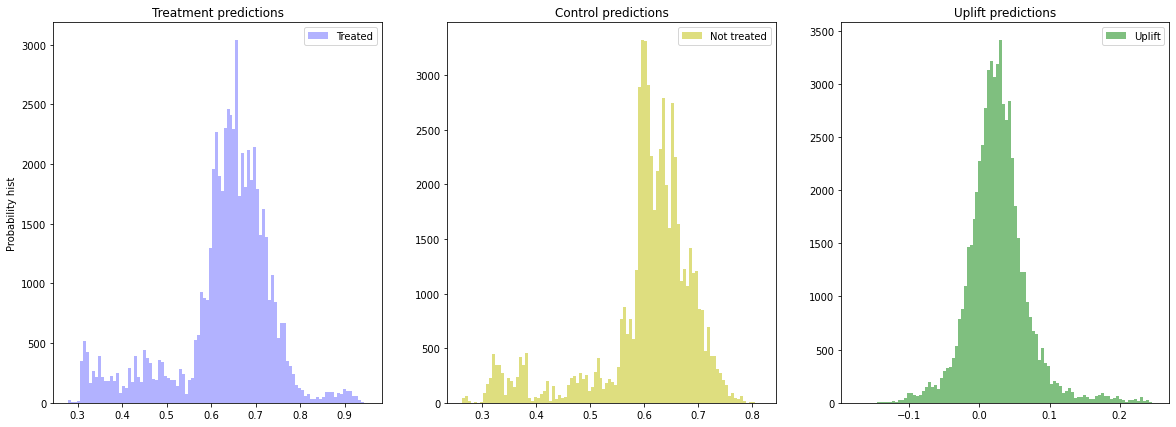

In [17]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds_(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

Посмотрим на результаты

In [18]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
2,TwoModels,0.062360
1,ClassTransformation,0.061775
0,SoloModel,0.041167


#### Вариант с деревом решений

In [19]:
X_train_tree = pd.concat([X_train.drop('gender', 1), 
                          pd.get_dummies(X_train['gender'], prefix='gender')], 1)
X_val_tree = pd.concat([X_val.drop('gender', 1), 
                          pd.get_dummies(X_val['gender'], prefix='gender')], 1)
features = [col for col in X_train_tree]

In [20]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [21]:
import numpy as np
tree_lift =  np.array(uplift_model.predict(X_val_tree.values))[0]

uplift_tree_30 = uplift_at_k(y_val, tree_lift, treat_val, strategy='overall')
print(f'uplift@30%: {uplift_tree_30:.4f}')
models_results['approach'].append('TreeModels')
models_results['uplift@30%'].append(uplift_tree_30)

NameError: name 'uplift_model' is not defined

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if len(self.column)==1:
          return X[:,self.column].reshape( -1,1)
        else:
          return X[:, self.column]  

In [ ]:
from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

In [ ]:
class PandasFeatureUnion(FeatureUnion):
    '''
    применить разные преобразования к разным столбцам,
    а затем объединить их вместе для дальнейшей обработки / процесса машинного обучения
    '''
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
    
class FeatureSelectorPd(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        print(self.column)
        return X[self.column]


    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        print('ohe')
        result = pd.get_dummies(X, prefix=self.key)
        for col_ in self.columns:
            if col_ not in result.columns:
                result[col_] = 0
        return result[self.columns]

In [ ]:
from sklearn.pipeline import Pipeline

encoder1 =Pipeline([('ohe',OHEEncoder(['gender']))])

estimator = CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True)
ct = ClassTransformation(estimator=estimator)




my_pipeline = Pipeline([
    ('encoder', PandasFeatureUnion([('1',encoder1)])),
    ('model',ct)
])



my_pipeline = my_pipeline.fit(   X=X_train, y = y_train, model__treatment=treat_train)


In [ ]:

uplift_predictions = my_pipeline.predict(X_val)

uplift_30 = uplift_at_k(y_val, uplift_predictions, treat_val, strategy='overall')
print(f'uplift@30%: {uplift_30:.4f}')

In [ ]:

models_results['approach'].append('ClassTransformation-pipeline')
models_results['uplift@30%'].append(uplift_30)


In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html


### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost